# Inhomogeneous Gaussian target with diagonal covariance matrix.

In [1]:
import numpy as np
import jax
import matplotlib.pyplot as plt

In [2]:
# set up true mean and covariance matrix

mu = np.ones(100)

sd = np.linspace(0.01, 1, 100)

cov = np.zeros((100, 100))

for i in range(100):
    cov[i, i] = sd[i]**2

In [3]:
# define necessary functions for implementation

# multivariate gaussian density
def multivariate_gaussian(x, mu, cov):
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).dot(np.linalg.inv(cov))).dot((x-mu))
    return float(part1 * np.exp(part2))

# log of gaussian density
def log_gauss(x, mu, cov):
    scale = np.linalg.cholesky(cov)
    v = jax.lax.linalg.triangular_solve(
      scale, x - mu, left_side=True, lower=True
    )
    return -0.5 * np.sum(v * v)


# gradient of log gaussian density
def grad_log_gauss(x,mu,cov):
    scale = np.linalg.cholesky(cov)
    v = jax.lax.linalg.triangular_solve(
      scale, x - mu, left_side=True, lower=True
    )
    return - jax.lax.linalg.triangular_solve(
      np.transpose(scale), v, left_side=True, lower=False
    )


# Fisher MALA algorithm

## step 1. simple MALA for initialisation

In [4]:
# initialisation
lam = 10 # default value

average_acc_rate = 0.574 # adapt step size toward achieving this acceptance rate.
rho = 0.015


rng = np.random.default_rng(42)
# number of iteration
N = 500

# initialise step size which is sigma^2 in paper
# 0.002 seems reasonable from trials
step_size = 0.0005

acceptance_rate_collection =  []
#initial sample obtained by drawing from standard normal as stated

x = rng.normal(0,1,100) # initial value

# 500 iterations.
for _ in range(N):

    print(f'---------iteration:{_}')

    # obtain x' through the formula
    y = x + (step_size/2) * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,len(mu))

    # Metropolis
    u = rng.uniform(0, 1)

    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(len(mu))) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(len(mu))))
    print(f'log acceptance rate:{log_acc_rate}')
    # if u < acceptance rate, we accept the sample
    if np.log(u) < log_acc_rate:
        x = y

    else:
        x = x

    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))
    print(f'acceptance rate:{acc_rate}')
    acceptance_rate_collection.append(acc_rate)
    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    print(f'step size:{step_size}')


print(f'Final sample in first 500 iterations:{x}')
print(f'Final adapted step size in first 500 iterations:{step_size}')

---------iteration:0
log acceptance rate:-2231.5859375
acceptance rate:0.0
step size:0.000495695
---------iteration:1
log acceptance rate:-2555.6796875
acceptance rate:0.0
step size:0.00049142706605
---------iteration:2
log acceptance rate:-2198.060546875
acceptance rate:0.0
step size:0.0004871958790113095
---------iteration:3
log acceptance rate:-1651.3984375
acceptance rate:0.0
step size:0.0004830011224930221
---------iteration:4
log acceptance rate:-838.3193359375
acceptance rate:0.0
step size:0.0004788424828283572
---------iteration:5
log acceptance rate:-1531.98046875
acceptance rate:0.0
step size:0.00047471964905120505
---------iteration:6
log acceptance rate:-1004.87890625
acceptance rate:0.0
step size:0.00047063231287287416
---------iteration:7
log acceptance rate:-782.638671875
acceptance rate:0.0
step size:0.0004665801686590387
---------iteration:8
log acceptance rate:-946.9638671875
acceptance rate:0.0
step size:0.0004625629134068844
---------iteration:9
log acceptance rate:

C:\Users\kaixi\AppData\Local\Temp\ipykernel_21732\3313049361.py:43: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_acc_rate))


log acceptance rate:13.173095703125
acceptance rate:1
step size:0.0004067137737920551
---------iteration:46
log acceptance rate:-70.95068359375
acceptance rate:1.5364188415953732e-31
step size:0.0004032119681997055
---------iteration:47
log acceptance rate:8.109130859375
acceptance rate:1
step size:0.0004057884926765016
---------iteration:48
log acceptance rate:-157.14404296875
acceptance rate:0.0
step size:0.0004022946537545569
---------iteration:49
log acceptance rate:-217.646728515625
acceptance rate:0.0
step size:0.0003988308967857302
---------iteration:50
log acceptance rate:-209.891357421875
acceptance rate:0.0
step size:0.00039539696276440504
---------iteration:51
log acceptance rate:-82.27197265625
acceptance rate:1.8609568259061785e-36
step size:0.0003919925949150035
---------iteration:52
log acceptance rate:72.722900390625
acceptance rate:1
step size:0.00039449742759651034
---------iteration:53
log acceptance rate:-0.792724609375
acceptance rate:0.45260992646217346
step size:

The overflow warning is dealt with by function min(1, acc_rate).

In [5]:
# This can be used as a metric to choose a good initial step size
print(f'average acceptance rate:{np.mean(acceptance_rate_collection)}')

average acceptance rate:0.5318157465408714


## step 2. Fisher MALA

In [6]:
# initialisation
N = int(1.95 * 10**4)

# step_size_R is sigma_R^2 in the paper
step_size_R = step_size # adapted step size from final iteration above. place holder for normalised step size.
R = np.identity(len(mu)) # initialise the square root matrix with identity matrix.

# define function h as stated in proposition 1.
def h(z,v, step_size, R, mu, cov):
    return (1/2) * (z- v- (step_size/4)* (R @ (R.T)).dot(grad_log_gauss(v, mu, cov))).dot(grad_log_gauss(v, mu, cov))

In [7]:
acc_rate_collection = []

# collecting normalised preconditioning matrix of fisher algorithm for Frobenius norm calculation
normalised_preconditioner_fisher = []

for n in range(1,N+1):

    # append normalised matrix to a list for plotting Frobenius norm later
    normalised_preconditioner_fisher.append(R@R.T/(1/len(mu) * np.trace(R@R.T)))

    print(f"--Iteration {n}")

    y = x + step_size_R/2 * R.dot(R.T.dot(grad_log_gauss(x, mu, cov))) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,len(mu)))
    # print(f'new sample:{y}')



    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(x, y, step_size_R, R, mu, cov) -\
                     log_gauss(x, mu, cov) - h(y, x, step_size_R, R, mu, cov)))

    # collect acceptance rate
    acc_rate_collection.append(acc_rate)
    print(f"acc_rate: {acc_rate}")

    # compute adaptation signal for updating R later
    s = np.sqrt(acc_rate) * (grad_log_gauss(y, mu, cov) - grad_log_gauss(x, mu, cov))
    # print(f'Rao-Blackwellized score function increment:{s}')

    # use s to adapt R based on proposition 4
    if n == 1:
        r1 = 1/(1+ np.sqrt(lam/(lam + np.dot(s,s))))
        R = (1/ np.sqrt(lam))* (R - r1 * (np.outer(s,s)/(lam + np.dot(s,s))))
        # print(f'1st square root matrix:{R}')
    else:
        phi = (R.T).dot(s)
        r = 1/(1+ np.sqrt(1/ (1+np.dot(phi,phi))))
        R = R - r * np.outer((R.dot(phi)),phi)/(1+ np.dot(phi,phi))
        # print(f'square root matrix:{R}')

    # adapt step size using the formula. mistake here in 1st version
    # let the step size adapt as before in Simple MALA
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    print(f'step size:{step_size}')

    # normalise the step size for the proposal in next iteration.
    step_size_R = step_size / ((1/len(mu)) * np.trace(R @ (R.T)))

    print(f"normalised step size: {step_size_R}")

    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)

    if u < acc_rate:
        x = y

    else:
        x = x

--Iteration 1
acc_rate: 1
step size:0.00036304141386710816
normalised step size: 0.003667051324098795
--Iteration 2
acc_rate: 0.7821959257125854
step size:0.0003641751700155892
normalised step size: 0.0037151136618278425
--Iteration 3
acc_rate: 1
step size:0.00036650224935198876
normalised step size: 0.003775086311870391
--Iteration 4
acc_rate: 0.9786998629570007
step size:0.00036872710050328154
normalised step size: 0.003836022432488265
--Iteration 5
acc_rate: 1
step size:0.00037108326667549746
normalised step size: 0.0039003424351690768
--Iteration 6
acc_rate: 0.9738902449607849
step size:0.00037330915535167315
normalised step size: 0.003962450052017499
--Iteration 7
acc_rate: 0.9951059222221375
step size:0.0003756671957937482
normalised step size: 0.004018202731124176
--Iteration 8
acc_rate: 0.9960920810699463
step size:0.0003780456880206826
normalised step size: 0.004079712313444084
--Iteration 9
acc_rate: 1
step size:0.00038046139996713473
normalised step size: 0.00414443607144389

In [8]:
# print(f'Final sample after burn-in iterations:{x}')
print(f'Final step size after burn-in iterations:{step_size}')
print(f'Final adapted normalised step size after burn-in iterations:{step_size_R}')
print(f'Average acceptance rate:{np.mean(acc_rate_collection)}')
print(f'Adapted square root matrix:\n {R}')

Final step size after burn-in iterations:0.20181699530318226
Final adapted normalised step size after burn-in iterations:4122.2951069405835
Average acceptance rate:0.5965225939748283
Adapted square root matrix:
 [[ 9.94099898e-05  2.43468218e-05  1.20679881e-05 ... -1.16698785e-07
   4.23181618e-07 -6.45036177e-07]
 [-7.24327716e-05  2.04187414e-04 -1.53736301e-05 ... -1.16155284e-06
  -3.00073642e-06 -1.13574935e-06]
 [-5.40917147e-05  2.15046284e-05  3.30640723e-04 ...  7.64659659e-07
  -2.99739795e-06  6.16677231e-06]
 ...
 [-4.13620648e-05  6.15027868e-05  8.75644038e-05 ...  1.17998006e-02
  -6.44426734e-06 -1.48079814e-04]
 [-1.74273115e-04  1.60201383e-04  7.64576126e-05 ... -9.37108717e-05
   1.18684789e-02  9.47004564e-05]
 [ 5.43412454e-05  1.90178595e-04 -2.13375617e-04 ...  8.48085506e-05
  -1.36599602e-04  1.19909806e-02]]


Display the matrices for comparison between the final normalised Fisher preconditioner and the true normalised covariance matrix.

In [9]:
final_normalised_fisher_preconditioner = (R@R.T)/(1/len(mu) * np.trace(R@R.T))
print(f'normalised preconditioning matrix:{final_normalised_fisher_preconditioner}')

normalised preconditioning matrix:[[ 2.97291859e-04 -7.53404298e-06  2.90091119e-06 ... -3.35858805e-05
  -1.36490499e-04  5.31196775e-05]
 [-7.53404298e-06  1.20007943e-03  2.42970717e-06 ...  1.29919433e-04
   5.30488931e-05  5.19850197e-04]
 [ 2.90091119e-06  2.42970717e-06  2.66839207e-03 ...  4.84603613e-04
  -7.69789045e-05 -1.97354063e-05]
 ...
 [-3.35858805e-05  1.29919433e-04  4.84603613e-04 ...  2.86083149e+00
  -2.12791763e-02 -1.47898946e-02]
 [-1.36490499e-04  5.30488931e-05 -7.69789045e-05 ... -2.12791763e-02
   2.89381560e+00 -9.73360583e-03]
 [ 5.31196775e-05  5.19850197e-04 -1.97354063e-05 ... -1.47898946e-02
  -9.73360583e-03  2.95244581e+00]]


In [10]:
print(f'normalised true covariance matrix:{cov/(1/len(mu) * np.trace(cov))}')

normalised true covariance matrix:[[2.95551943e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.18220777e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.65996749e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.83848086e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.89670460e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.95551943e+00]]


## Sampling phase of FisherMALA

In [ ]:
# initialisation
N = int(2 * 10**4)
# sample collection each row for each dimension, column for number of samples.
Fisher_MALA_samples = np.zeros((100, N+1))
Fisher_MALA_samples[:, 0] = np.array(rng.normal(0,1,100))
for n in range(1, N+1):
    y = Fisher_MALA_samples[:,n-1] + step_size_R/2 * R.dot(R.T.dot(grad_log_gauss(Fisher_MALA_samples[:,n-1], mu, cov))) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,len(mu)))

    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(Fisher_MALA_samples[:, n-1], y, step_size_R, R, mu, cov) -\
                     log_gauss(Fisher_MALA_samples[:, n-1], mu, cov) - h(y, Fisher_MALA_samples[:, n-1], step_size_R, R, mu, cov)))
    print(acc_rate)


    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)

    if u < acc_rate:
        Fisher_MALA_samples[:,n] = y
    else:
        Fisher_MALA_samples[:,n]  = Fisher_MALA_samples[:,n-1]

1
1
1
1
1
1
1
1
1


<ipython-input-123-760c56e8e26a>:14: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(Fisher_MALA_samples[:, n-1], y, step_size_R, R, mu, cov) -\


Streaming output truncated to the last 5000 lines.
1
0.092761576
0.018190913
1
0.9062975
1
1
0.42076626
0.58238494
0.24882713
1
0.21823046
0.3531578
0.087838426
0.1330219
0.076320544
1
0.60070217
0.49551365
0.313503
0.84695625
1
0.077894114
1
0.73207694
0.7211974
0.8818546
0.24014658
0.41318825
0.537945
0.9139917
1
0.3676928
1
1
0.69764763
1
0.10139093
0.07340711
0.2772457
0.06720075
0.5023307
0.46697062
0.4915682
0.2666116
1
0.14554088
0.8843133
0.43374208
0.5332736
0.071637265
0.6233803
0.28194636
0.5791109
1
0.14213523
0.5727591
0.2808761
0.9179956
0.5147662
0.9837963
0.2556149
1
0.5392224
0.49160993
0.5283705
0.23852181
0.8929565
1
0.031216236
1
0.6813323
1
0.2294816
1
1
0.19512977
1
0.20976754
0.23986292
0.31117186
0.44891232
0.6651939
0.3004635
0.32475016
0.61974066
0.9583461
1
1
1
0.7765839
1
0.14859481
1
0.37760752
0.5390167
1
1
1
1
1
0.41108808
0.5188894
0.88265014
0.27781567
0.24573272
0.25889674
0.071732976
0.9174503
0.29857334
0.06537748
1
1
1
0.38683218
0.15001993
0.202527

# AdaMALA

## step1. 500 simple MALA initialisation to adapt step size.

In [11]:
rng = np.random.default_rng(36)
# number of iteration
N = 500
# initialise step size which is sigma^2 in paper
# 0.1 seems reasonable from trials
step_size = 0.01
acceptance_rate_collection =  []

#initial sample obtained by drawing from standard normal as stated
x = rng.normal(0,1,100)

# 500 iterations.
for _ in range(N):
    
    # obtain x' through the formula
    y = x + (step_size/2) * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,len(mu))

    # Metropolis
    u = rng.uniform(0, 1)
    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(len(mu))) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(len(mu))))

    # if u < acceptance rate, we accept the sample
    if np.log(u) < log_acc_rate:
        x = y
    else:
        x = x

    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))
    acceptance_rate_collection.append(acc_rate)
    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
print(f'Final adapted step size in first 500 iterations:{step_size}')

C:\Users\kaixi\AppData\Local\Temp\ipykernel_21732\2872283680.py:35: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_acc_rate))


Final adapted step size in first 500 iterations:0.0003906926401446386


## Another 500 iterations to adapt covariance matrix.

In [12]:
# initialisation the mean with final sample from step 1.
mean = x
# number of iteration
N = 500
normalised_preconditioner_ada = []
acc_rate_collection = []
for n in range(2, N+2):
    print(f'---------iteration:{n}')
    
    # obtain x' through the formula
    y = x + (step_size/2) * grad_log_gauss(x, mu, cov) + np.sqrt(step_size) * rng.normal(0,1,len(mu))

    # Metropolis
    u = rng.uniform(0, 1)
    log_acc_rate = log_gauss(y, mu, cov) + log_gauss(x, y+step_size/2 *grad_log_gauss(y,mu,cov), step_size * np.identity(len(mu))) - \
            (log_gauss(x, mu, cov) + log_gauss(y, x + step_size/2 *grad_log_gauss(x,mu,cov) , step_size * np.identity(len(mu))))
    # if u < acceptance rate, we accept the sample
    if np.log(u) < log_acc_rate:
        x = y

    else:
        x = x
    # Adapt empirical covariance
    if n == 2:
        Sigma = (1./n)* np.outer((x-mean),(x-mean)) + lam * np.identity(len(mu))

    else:
        Sigma = ((n-2.)/(n-1.)) * Sigma + (1./n) * np.outer((x-mean), (x-mean))
    # append normalised matrix for plot of Frobenius norm
    normalised_preconditioner_ada.append(Sigma/(1/len(mu) * np.trace(Sigma)))
    # adapt the empirical mean
    mean = mean + (1./n) * (x - mean)
    # adapt the step size toward 0.574
    acc_rate = min(1, np.exp(log_acc_rate))
    acc_rate_collection.append(acc_rate)
    print(f'acceptance rate:{acc_rate}')
    
    # Step size adaptation towards the optimal acceptance rate
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))
    print(f'step size:{step_size}')

print(f'Final empirical covariance after 500 iterations:{Sigma}')
print(f'Final empirical mean after 500 iterations:{mean}')
print(f'Final adapted step size after first 1000 iterations:{step_size}')
print(f'Average acceptance rate:{np.mean(acc_rate_collection)}')

---------iteration:2
log acceptance rate:441.081787109375
acceptance rate:1
step size:0.0003931891661151628
---------iteration:3


C:\Users\kaixi\AppData\Local\Temp\ipykernel_21732\1625258440.py:48: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_acc_rate))


log acceptance rate:256.831787109375
acceptance rate:1
step size:0.00039570164488663865
---------iteration:4
log acceptance rate:89.73876953125
acceptance rate:1
step size:0.00039823017839746424
---------iteration:5
log acceptance rate:232.7623291015625
acceptance rate:1
step size:0.000400774869237424
---------iteration:6
log acceptance rate:72.773193359375
acceptance rate:1
step size:0.0004033358206518511
---------iteration:7
log acceptance rate:106.537841796875
acceptance rate:1
step size:0.0004059131365458164
---------iteration:8
log acceptance rate:-124.4296875
acceptance rate:0.0
step size:0.0004024182244401569
---------iteration:9
log acceptance rate:-182.9195556640625
acceptance rate:0.0
step size:0.0003989534035277272
---------iteration:10
log acceptance rate:242.02783203125
acceptance rate:1
step size:0.00040150271577626934
---------iteration:11
log acceptance rate:-30.48046875
acceptance rate:5.787627728416275e-14
step size:0.000398045777393436
---------iteration:12
log accep

## For remaining burn-in iterations adapt covariance using proposal in equation (7) in the paper.

In [13]:
# initialisation
N = int(1.9 * 10**4)
step_size_R = step_size / ((1/len(mu)) * np.trace(Sigma))
acc_rate_collection = []
mean = mean # final mean value from above
Sigma = Sigma # final covariance from above.

# for n in range(3,N+3):
for n in range(502,N+502):
    # print(f"--Iteration {n}")
    R = np.linalg.cholesky(Sigma)
    
    y = x + (step_size_R/2) * Sigma.dot(grad_log_gauss(x, mu, cov)) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,len(mu)))

    # use equation (3.8) to compute acceptance rate
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(x, y, step_size_R, R, mu, cov) -\
                     log_gauss(x, mu, cov) - h(y, x, step_size_R, R, mu, cov)))
    
    # collect acceptance rate
    acc_rate_collection.append(acc_rate)
    print(f'acceptance rate:{acc_rate}')
    
    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)
    if u < acc_rate:
        x = y
    else:
        x = x
        
    Sigma = ((n-2.)/(n-1.)) * Sigma + (1./n) * np.outer((x-mean), (x-mean))
    mean = mean + (1./n) * (x - mean)

    # appending the normalised preconditioner for later plot of Frobenius norm
    normalised_preconditioner_ada.append(Sigma/(1/len(mu) * np.trace(Sigma)))

    # adapt step size
    step_size = step_size * (1+ rho * (acc_rate - average_acc_rate))

    # normalise the step size for the proposal in next iteration.
    step_size_R = step_size / ((1./len(mu)) * np.trace(Sigma))

acceptance rate:0.5474557876586914
acceptance rate:1
acceptance rate:0.8101398944854736
acceptance rate:0.9999144673347473
acceptance rate:0.7336222529411316
acceptance rate:0.8204236030578613
acceptance rate:0.6680944561958313
acceptance rate:0.2967410087585449
acceptance rate:0.25549623370170593
acceptance rate:0.016611065715551376
acceptance rate:0.006109135691076517
acceptance rate:1
acceptance rate:1
acceptance rate:0.778389036655426
acceptance rate:0.9985929727554321
acceptance rate:0.8409363031387329
acceptance rate:0.38677114248275757
acceptance rate:1
acceptance rate:1
acceptance rate:0.6255070567131042
acceptance rate:1
acceptance rate:1
acceptance rate:0.20141185820102692
acceptance rate:0.45903196930885315
acceptance rate:0.950645387172699
acceptance rate:0.4028414785861969
acceptance rate:1
acceptance rate:0.9332377910614014
acceptance rate:0.30756786465644836
acceptance rate:0.2938447594642639
acceptance rate:0.9626809358596802
acceptance rate:0.6599169373512268
acceptanc

In [14]:
print(f'Final empirical covariance after burn-in iterations:\n{Sigma}')
print(f'Final empirical mean after burn-in iterations:\n{mean}')
print(f'Average acceptance rate:{np.mean(acc_rate_collection)}')

Final empirical covariance after burn-in iterations:
[[ 9.17464861e-04  3.90304887e-06  1.14370830e-06 ... -1.36383913e-04
   3.70277918e-05 -9.46447600e-05]
 [ 3.90304887e-06  9.16415830e-04  8.98418970e-06 ...  2.78005285e-06
  -7.21071776e-04  5.22699773e-05]
 [ 1.14370830e-06  8.98418970e-06  1.39335370e-03 ...  2.80514901e-04
   6.54883201e-04  6.73767040e-05]
 ...
 [-1.36383913e-04  2.78005285e-06  2.80514901e-04 ...  2.64409656e-01
   1.41351832e-01  3.30098300e-02]
 [ 3.70277918e-05 -7.21071776e-04  6.54883201e-04 ...  1.41351832e-01
   7.70429426e-01  3.44295787e-02]
 [-9.46447600e-05  5.22699773e-05  6.73767040e-05 ...  3.30098300e-02
   3.44295787e-02  1.92858952e-01]]
Final empirical mean after burn-in iterations:
[ 9.9988633e-01  9.9949253e-01  1.0001273e+00  1.0016514e+00
  1.0002974e+00  1.0060980e+00  9.9561298e-01  9.9658233e-01
  9.9511468e-01  9.8273289e-01  9.8681188e-01  1.0121651e+00
  1.0055296e+00  1.0112900e+00  1.0187215e+00  9.8569626e-01
  1.0152210e+00  1.0

In [15]:
final_normalised_ada_preconditioner= Sigma/(np.trace(Sigma)/len(mu))
print(f'normalised adaMALA precondioner:{final_normalised_ada_preconditioner}')

normalised adaMALA precondioner:[[ 5.67464183e-03  2.41408749e-05  7.07398750e-06 ... -8.43552586e-04
   2.29021803e-04 -5.85390392e-04]
 [ 2.41408749e-05  5.66815344e-03  5.55684048e-05 ...  1.71949956e-05
  -4.45992456e-03  3.23296741e-04]
 [ 7.07398750e-06  5.55684048e-05  8.61807744e-03 ...  1.73502186e-03
   4.05053945e-03  4.16733849e-04]
 ...
 [-8.43552586e-04  1.71949956e-05  1.73502186e-03 ...  1.63540879e+00
   8.74279829e-01  2.04170176e-01]
 [ 2.29021803e-04 -4.45992456e-03  4.05053945e-03 ...  8.74279829e-01
   4.76520817e+00  2.12951510e-01]
 [-5.85390392e-04  3.23296741e-04  4.16733849e-04 ...  2.04170176e-01
   2.12951510e-01  1.19285820e+00]]


## Sampling phase of AdaMALA

In [25]:
# initialisation
N = int(2 * 10**4)
# sample collection each row for each dimension, column for number of samples.
AdaMALA_samples = np.zeros((100, N+1))
AdaMALA_samples[:, 0] = np.array(rng.normal(0,1,100))
for n in range(1, N+1):
    R = np.linalg.cholesky(Sigma)
    y = AdaMALA_samples[:,n-1] + (step_size_R/2) * Sigma.dot(grad_log_gauss(AdaMALA_samples[:,n-1], mu, cov)) + np.sqrt(step_size_R) * R.dot(rng.normal(0,1,len(mu)))
    # using proposition 1 to compute acceptance rate, mistake for using step_size_R as step size
    acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(AdaMALA_samples[:, n-1], y, step_size_R, R, mu, cov) -\
                     log_gauss(AdaMALA_samples[:, n-1], mu, cov) - h(y, AdaMALA_samples[:, n-1], step_size_R, R, mu, cov)))

    # Metropolis step - accept/ reject y  with probability acc_rate
    u = rng.uniform(0, 1)
    if u < acc_rate:
        AdaMALA_samples[:,n] = y
    else:
        AdaMALA_samples[:,n]  = AdaMALA_samples[:,n-1]

C:\Users\kaixi\AppData\Local\Temp\ipykernel_21732\2299928318.py:10: RuntimeWarning: overflow encountered in exp
  acc_rate = min(1, np.exp(log_gauss(y, mu, cov) + h(AdaMALA_samples[:, n-1], y, step_size_R, R, mu, cov) -\


In [27]:
AdaMALA_samples

array([[-0.97644588,  0.6826095 ,  0.94657042, ...,  1.01004832,
         0.98949924,  0.98949924],
       [ 0.33305849,  0.46185417,  0.59331731, ...,  0.99693565,
         1.00195387,  1.00195387],
       [-0.13825805,  0.02262416,  0.15280091, ...,  1.01681482,
         1.01107822,  1.01107822],
       ...,
       [ 0.48481197,  1.50342006,  0.91947447, ...,  1.19915428,
         0.69845917,  0.69845917],
       [-0.26509483,  1.90155868,  0.78317054, ...,  1.62720161,
         1.97807887,  1.97807887],
       [-0.06354454,  0.36779912,  0.24935735, ...,  0.88325454,
         0.8664753 ,  0.8664753 ]])

# Frobenius norm

In [16]:
normalised_cov = cov/(1/len(mu) * np.trace(cov))
# compute the difference between the true covariance matrix and each of collected adapting covariance matrix
difference_ada = normalised_preconditioner_ada - normalised_cov
difference_fisher = normalised_preconditioner_fisher - normalised_cov
# empty list to store the Frobenius norm
fro_norm_ada = []
fro_norm_fisher = []
# compute the Frobenius norm of the deviation from the true covariance matrix. 
for i in difference_ada:
    fro_norm_ada.append(np.linalg.norm(i))
for j in difference_fisher:
    fro_norm_fisher.append(np.linalg.norm(j))

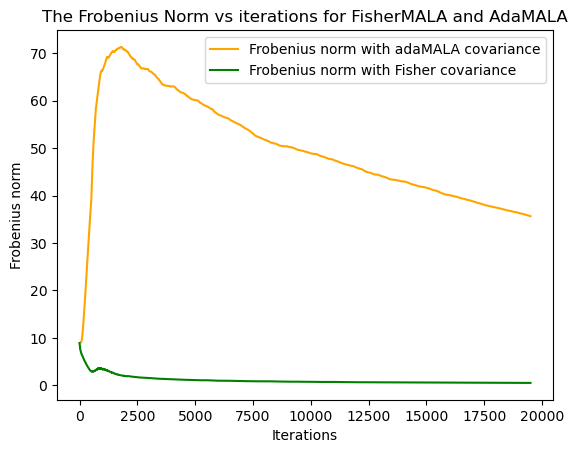

In [21]:
iterations = np.arange(0, int(1.95 * 10**4))
plt.plot(iterations, fro_norm_ada, label = 'Frobenius norm with adaMALA covariance', color = 'orange')
plt.plot(iterations, fro_norm_fisher, label = 'Frobenius norm with Fisher covariance', color = 'green')
plt.ylabel('Frobenius norm')
plt.xlabel('Iterations')
plt.title("The Frobenius Norm vs iterations for FisherMALA and AdaMALA")
plt.legend()
plt.show()

Compare to the plot in the paper.

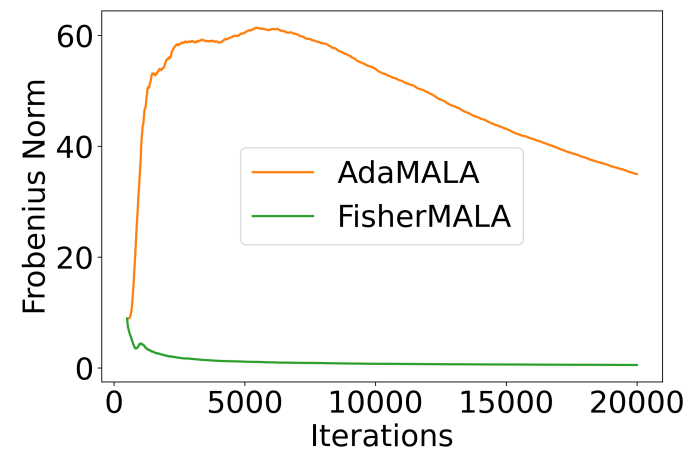

In [18]:
print(f'FisherMALA Frobenius norm converges to:{fro_norm_fisher[-1]}')
print(f'AdaMALA Frobenius norm after 19500 iterations:{fro_norm_ada[-1]}')

FisherMALA Frobenius norm converges to:0.4969814963523088
AdaMALA Frobenius norm after 19500 iterations:35.64789302423139


# Figure 2b Now plot the estimated standard deviation from the optimised precondtioning matrix from adaMALA and FisherMALA.

I extract the diagonal element of the final estimated normalised covariance matrix and square root them to obtain the standard deviation for each dimension.

In [19]:
# Extracting the diagonal elements of matrices
var_ada = np.diag(final_normalised_ada_preconditioner)
var_fisher = np.diag(final_normalised_fisher_preconditioner)

# standard deviation from AdaMALA estimation
sd_ada = np.sqrt(var_ada)
# standard deviation from FisherMALA estimation
sd_fisher = np.sqrt(var_fisher)

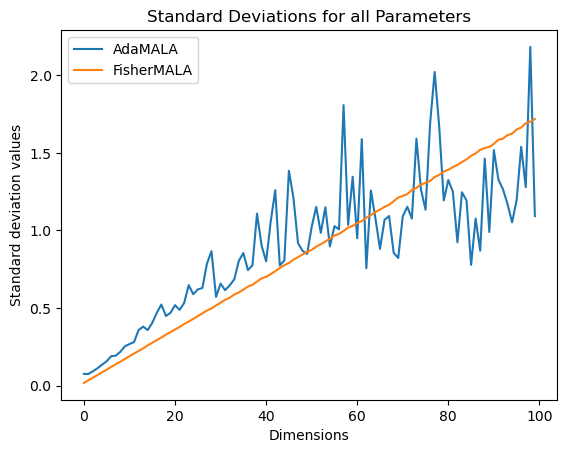

In [23]:
dimensions = np.linspace(0,99,100)
plt.plot(dimensions, sd_ada, label= 'AdaMALA')
plt.plot(dimensions, sd_fisher, label = 'FisherMALA')
plt.title('Standard Deviations for all Parameters')
plt.ylabel('Standard deviation values')
plt.xlabel('Dimensions')
plt.legend()

Plot from the paper.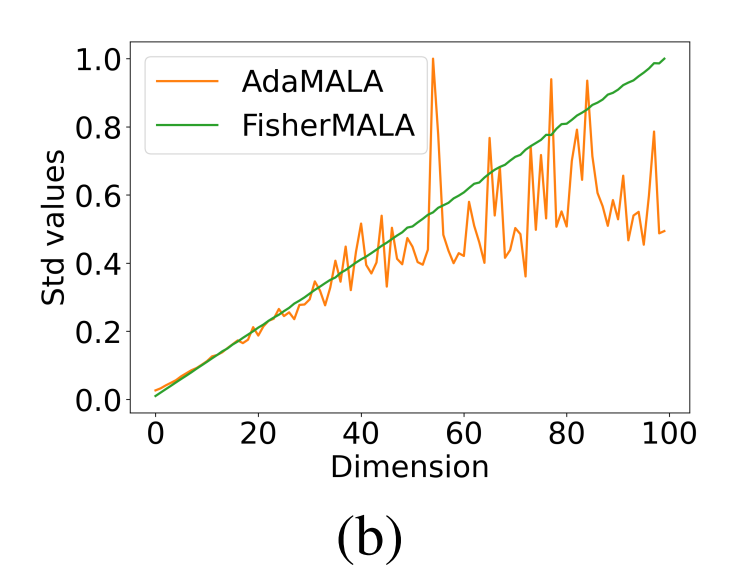